In [1]:
!pip install open_clip_torch
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [24]:
import os
import numpy as np
import torch

import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict


import open_clip

skimage.data.download_all()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [25]:
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Context length: 77
Vocab size: 49408


In [26]:
target_labels = ["page","chelsea","astronaut","rocket",
                 "motorcycle_right","camera","horse","coffee",
                 'logo']

In [27]:
all_names = []
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    all_names.append(os.path.splitext(filename)[0])

set(all_names)

{'astronaut',
 'brick',
 'bw_text',
 'camera',
 'cell',
 'checker_bilevel',
 'chelsea',
 'chessboard_GRAY',
 'chessboard_RGB',
 'clock_motion',
 'coffee',
 'coins',
 'color',
 'eagle',
 'foo3x5x4indexed',
 'grass',
 'gravel',
 'green_palette',
 'horse',
 'hubble_deep_field',
 'ihc',
 'logo',
 'microaneurysms',
 'moon',
 'motorcycle_left',
 'motorcycle_right',
 'page',
 'palette_color',
 'palette_gray',
 'phantom',
 'retina',
 'rocket',
 'skin',
 'text',
 'truncated'}

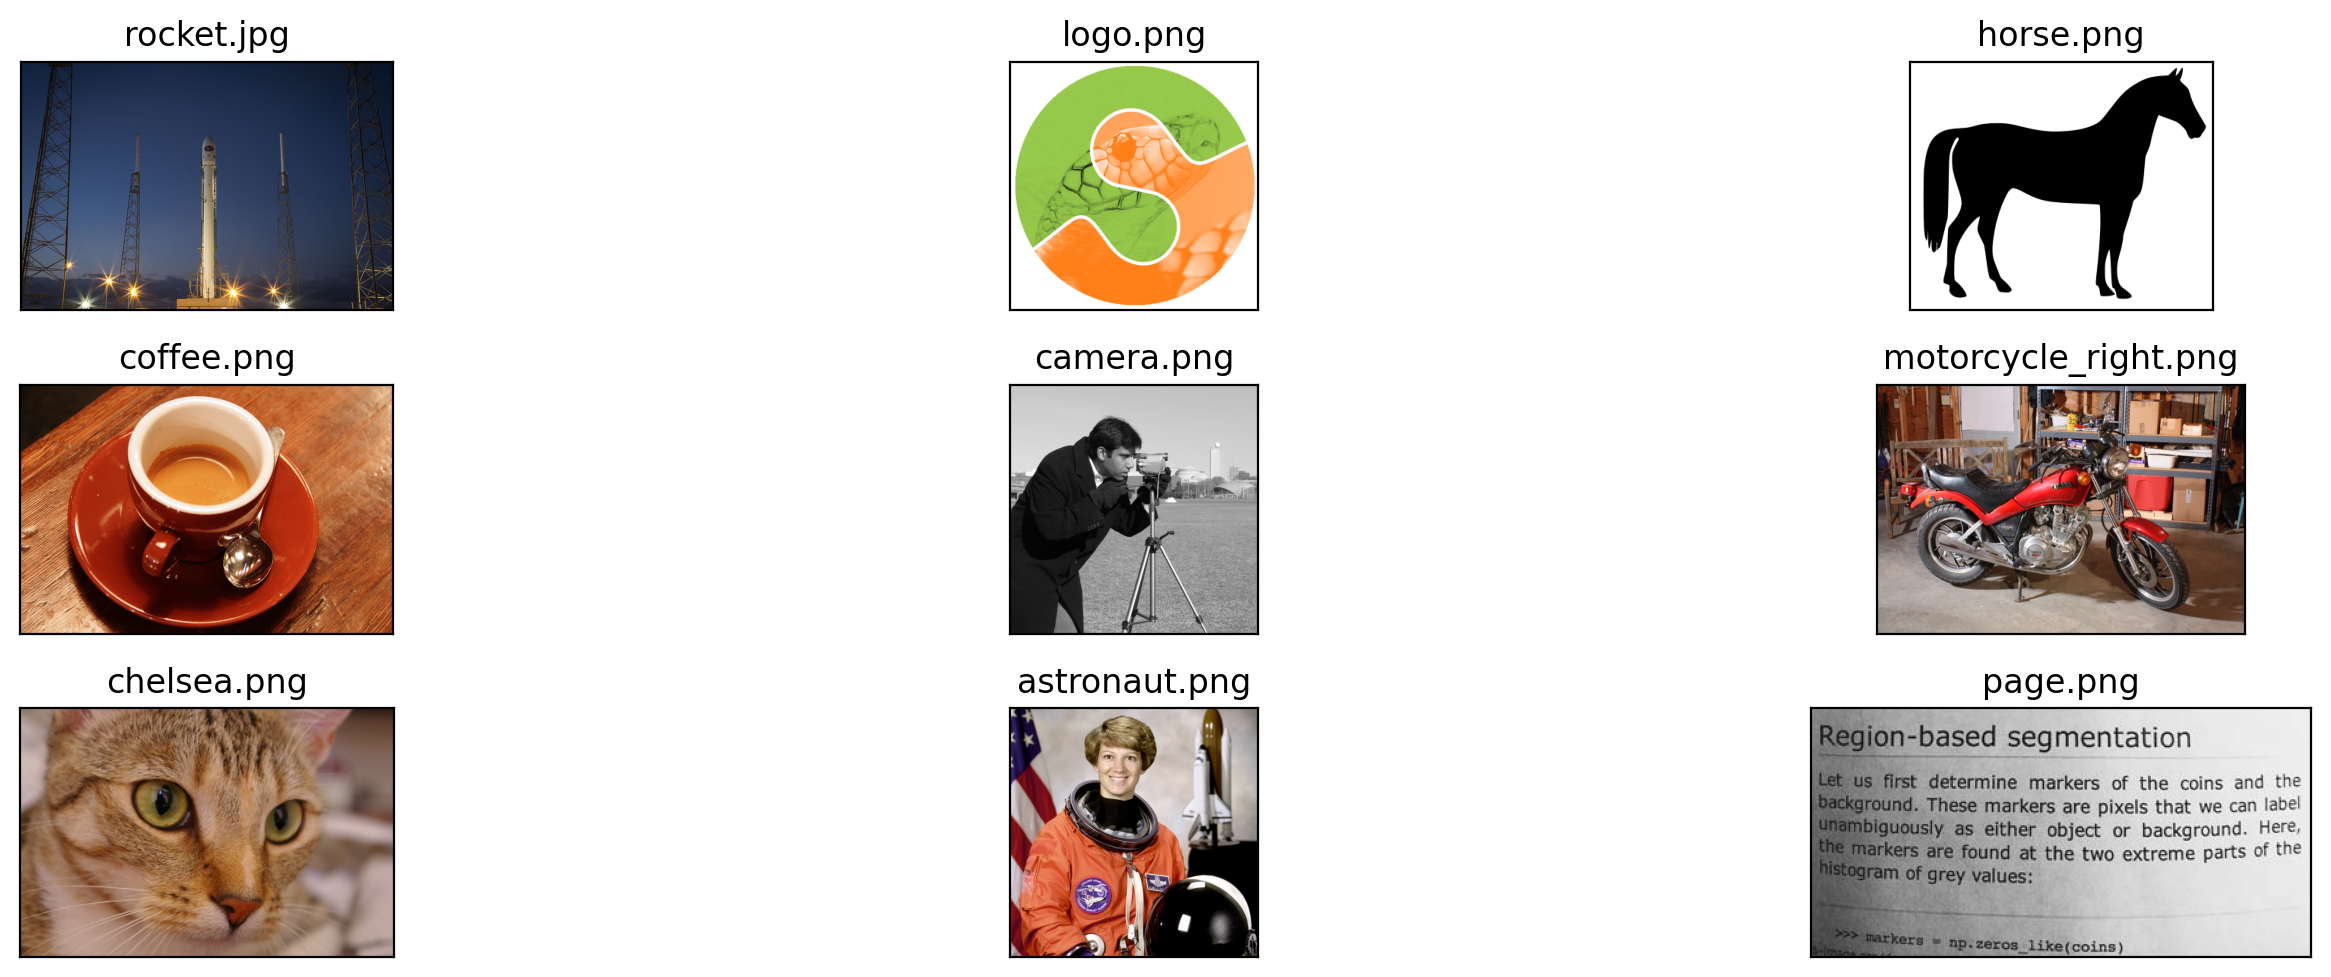

In [28]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in target_labels:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(3, 3, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    # texts.append(descriptions[name])

plt.tight_layout()

In [29]:
image_input = torch.tensor(np.stack(images))
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

image_features.size()

torch.Size([9, 512])

In [30]:
input_description = "A motorcycle From left side"
text_tokens = tokenizer([input_description])

In [31]:
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)

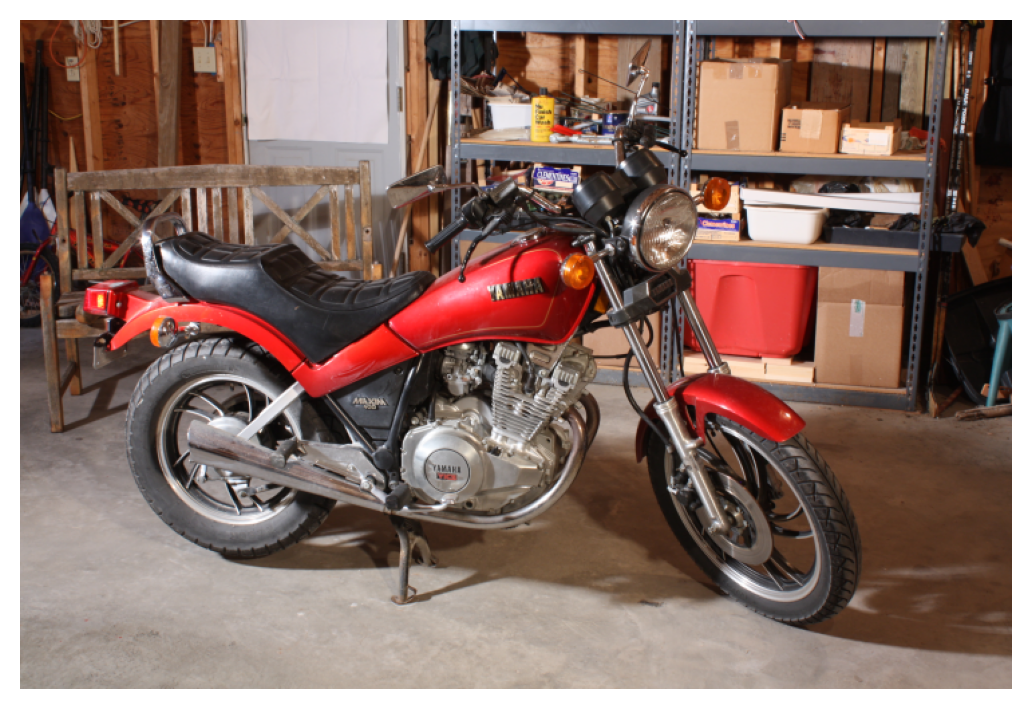

In [32]:
plt.axis('off')
plt.imshow(original_images[top_probs.argmax().item()])

In [35]:
from huggingface_hub import HfApi

api = HfApi(token=HF_token)

In [34]:
import app

In [36]:
import os
os.makedirs('to_upload', exist_ok=True)

In [37]:
!cp app.py to_upload
!cp requirements.txt to_upload

In [38]:
api.upload_folder(
    folder_path="./to_upload",
    repo_id="Azreal18/Open_Clip",
    repo_type="space",
)

CommitInfo(commit_url='https://huggingface.co/spaces/Azreal18/Open_Clip/commit/e04a5898b5862ccdd0b101d79d02b160631e7afe', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e04a5898b5862ccdd0b101d79d02b160631e7afe', pr_url=None, pr_revision=None, pr_num=None)